# Prototypage de Modèles - Avec et Sans Feature Engineering

In [1]:
# %%
# ===================================================================
# BLOC DE DÉMARRAGE UNIVERSEL (LOCAL + COLAB) - V2
# ===================================================================

import pandas as pd
import numpy as np
import yaml
import sys
import os

# --- 1. Détection de l'environnement ---
IN_COLAB = 'google.colab' in sys.modules

# --- 2. Configuration des chemins ---
if IN_COLAB:
    print("Environnement Google Colab détecté.")
    from google.colab import drive
    drive.mount('/content/drive')

    # On suppose que le projet est cloné à la racine de /content/
    project_root = '/content/detectionFraudeTemporaire'

    # Cloner le projet si nécessaire
    if not os.path.exists(project_root):
        # --- MODIFIEZ L'URL AVEC CELLE DE VOTRE PROJET ---

        repo_url = "https://{token}@github.com/Mbogneng-Junior/detectionFraudeTemporaire.git"
        !git clone {repo_url} {project_root}

    os.chdir(project_root)
    sys.path.append('src')

# --- 3. Chargement de la configuration et des données ---
config_path = 'config/main_config.yaml' if os.path.exists('config/main_config.yaml') else '../config/main_config.yaml'

with open(config_path, 'r') as file:
    config_full = yaml.safe_load(file)

config = config_full['colab'] if IN_COLAB else config_full['local']
data_path = config['data']['raw_data_path']

# En local, le chemin est relatif à la racine du projet, et le notebook est dans un sous-dossier
if not IN_COLAB:
    data_path = f'../{data_path}'
    sys.path.append('../src') # Ajouter src/ au path uniquement en local

df = pd.read_csv(data_path)
print("\n--- Données chargées avec succès ---")
display(df.head())

# --- 4. Importations communes ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from features.build_features import preprocess_data
from imblearn.over_sampling import SMOTE

Environnement Google Colab détecté.
Mounted at /content/drive
Cloning into '/content/detectionFraudeTemporaire'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 46 (delta 14), reused 42 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 652.34 KiB | 18.64 MiB/s, done.
Resolving deltas: 100% (14/14), done.

--- Données chargées avec succès ---


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Version 1 : Sans Feature Engineering

In [2]:
# Préparation des données SANS feature engineering
X_train_v1, y_train_v1, X_test_v1, y_test_v1 = preprocess_data(df, apply_feature_engineering=False)

# Appliquer SMOTE uniquement sur le jeu d'entraînement
print("\nApplication de SMOTE sur la V1...")
smote = SMOTE(random_state=42)
X_train_resampled_v1, y_train_resampled_v1 = smote.fit_resample(X_train_v1, y_train_v1)


Taille du jeu d'entraînement : 227845 lignes
Taille du jeu de test : 56962 lignes

Application de SMOTE sur la V1...


## Version 2 : Avec Feature Engineering

In [3]:
# Préparation des données AVEC feature engineering
X_train_v2, y_train_v2, X_test_v2, y_test_v2 = preprocess_data(df, apply_feature_engineering=True)

# Appliquer SMOTE uniquement sur le jeu d'entraînement
print("\nApplication de SMOTE sur la V2...")
smote = SMOTE(random_state=42)
X_train_resampled_v2, y_train_resampled_v2 = smote.fit_resample(X_train_v2, y_train_v2)

Application du Feature Engineering...
Taille du jeu d'entraînement : 227845 lignes
Taille du jeu de test : 56962 lignes

Application de SMOTE sur la V2...


## Entraînement et Évaluation d'un Modèle de Référence

 Nous allons utiliser une Régression Logistique comme premier modèle simple pour comparer les deux approches.


--- Évaluation pour : Version 1 (Sans FE) ---
Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      0.97      0.99     56887
  Fraude (1)       0.04      0.89      0.08        75

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.99     56962

AUC-ROC: 0.9855
AUC-PR (Precision-Recall): 0.7650


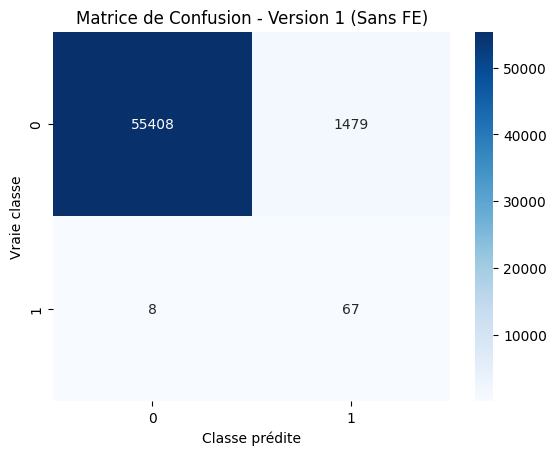


--- Évaluation pour : Version 2 (Avec FE) ---
Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      0.95      0.98     56887
  Fraude (1)       0.03      0.92      0.05        75

    accuracy                           0.95     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.95      0.98     56962

AUC-ROC: 0.9862
AUC-PR (Precision-Recall): 0.7655


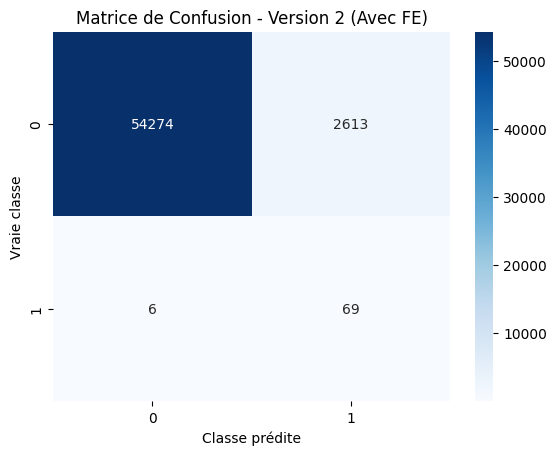

In [4]:
def train_and_evaluate(X_train, y_train, X_test, y_test, version_name):
    """Fonction pour entraîner et évaluer un modèle."""
    print(f"\n--- Évaluation pour : {version_name} ---")

    # Entraînement
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train, y_train)

    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Évaluation
    print("Rapport de Classification :")
    print(classification_report(y_test, y_pred, target_names=['Légitime (0)', 'Fraude (1)']))

    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)

    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR (Precision-Recall): {auc_pr:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de Confusion - {version_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()

# Évaluation de la version 1 (sans feature engineering)
train_and_evaluate(X_train_resampled_v1, y_train_resampled_v1, X_test_v1, y_test_v1, "Version 1 (Sans FE)")

# %%
# Évaluation de la version 2 (avec feature engineering)
train_and_evaluate(X_train_resampled_v2, y_train_resampled_v2, X_test_v2, y_test_v2, "Version 2 (Avec FE)")

## Étape 3 : Entraînement de Modèles Plus Puissants

La Régression Logistique nous a montré que le Feature Engineering est prometteur. Utilisons maintenant des modèles plus complexes (Random Forest, XGBoost) pour voir s'ils peuvent mieux exploiter ces nouvelles features. Nous travaillerons uniquement sur la **Version 2 (Avec FE)**

In [13]:
# Importation des nouveaux modèles
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# %%
# Mise à jour de notre fonction d'évaluation pour accepter n'importe quel modèle
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Fonction générique pour entraîner et évaluer un modèle."""
    print(f"\n--- Évaluation pour : {model_name} ---")

    # Entraînement
    model.fit(X_train, y_train)

    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Évaluation
    print("Rapport de Classification :")
    print(classification_report(y_test, y_pred, target_names=['Légitime (0)', 'Fraude (1)']))

    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)

    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR (Precision-Recall): {auc_pr:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()



 ## Étape 3 (étendue) : Grand Tournoi des Modèles

 Nous allons maintenant évaluer une plus grande variété de modèles sur notre jeu de données V2 (avec Feature Engineering) pour identifier les approches les plus performantes

In [8]:
# Importations supplémentaires nécessaires
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import StackingClassifier
from tensorflow import keras
from tensorflow.keras import layers
# La fonction `train_and_evaluate_model` existe déjà, nous la réutiliserons.


 ### A. XGBoost
 scale_pos_weight est un hyperparamètre très utile pour les classes déséquilibrées
 On le calcule comme : (nombre d'exemples négatifs / nombre d'exemples positifs)
 Dans notre cas, SMOTE a déjà équilibré le set d'entraînement, donc on peut le laisser à 1.


--- Évaluation pour : XGBoost (avec FE) ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:00:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      1.00      1.00     56887
  Fraude (1)       0.71      0.72      0.72        75

    accuracy                           1.00     56962
   macro avg       0.86      0.86      0.86     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9644
AUC-PR (Precision-Recall): 0.7805


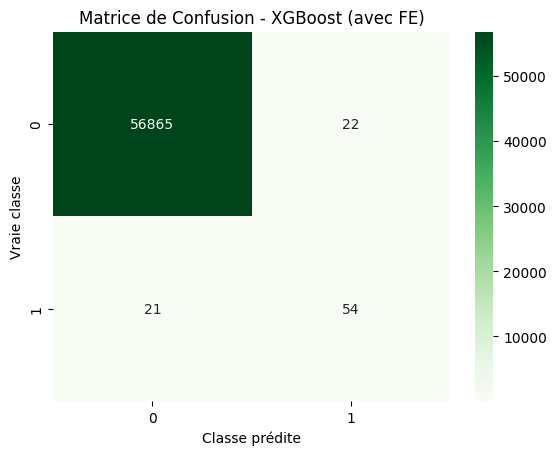

In [14]:
# --- Entraînement du XGBoost ---

xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
train_and_evaluate_model(xgb_model, X_train_resampled_v2, y_train_resampled_v2, X_test_v2, y_test_v2, "XGBoost (avec FE)")


 ### B. Random Forest (Simplifié)
 Pour une exécution plus rapide, nous réduisons le nombre d'arbres et leur profondeur.


--- Évaluation pour : Random Forest Simplifié (avec FE) ---
Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      1.00      1.00     56887
  Fraude (1)       0.46      0.80      0.59        75

    accuracy                           1.00     56962
   macro avg       0.73      0.90      0.79     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9866
AUC-PR (Precision-Recall): 0.8015


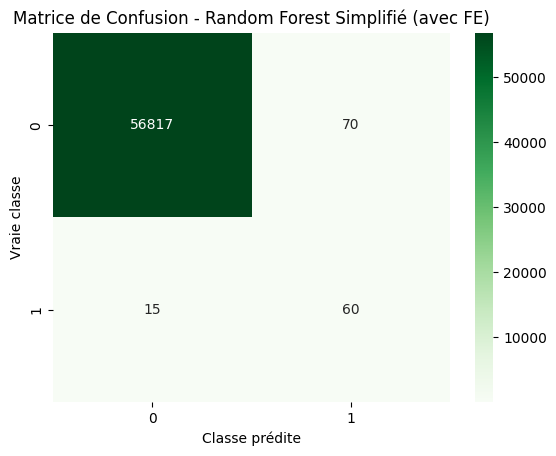

In [9]:
rf_simple_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
train_and_evaluate_model(rf_simple_model, X_train_resampled_v2, y_train_resampled_v2, X_test_v2, y_test_v2, "Random Forest Simplifié (avec FE)")


### C. Support Vector Machine (SVM)
 Les SVM sont très lents. Nous allons entraîner sur un échantillon pour avoir une idée rapide.


--- Évaluation pour : SVM (sur un échantillon) ---

--- Évaluation pour : SVM (avec FE, sur échantillon) ---
Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      0.97      0.98     56887
  Fraude (1)       0.04      0.89      0.07        75

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.98     56962

AUC-ROC: 0.9841
AUC-PR (Precision-Recall): 0.7698


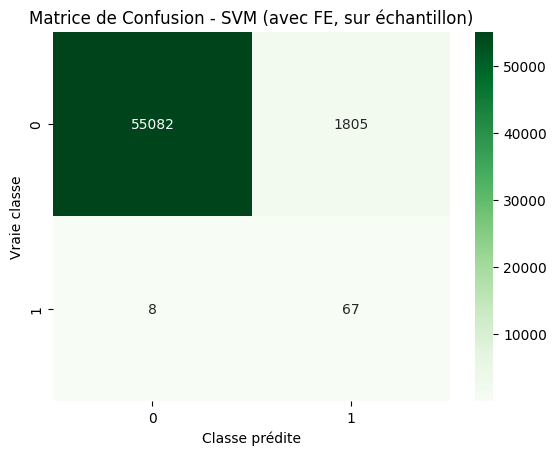

In [10]:
print("\n--- Évaluation pour : SVM (sur un échantillon) ---")
# Créer un échantillon du set d'entraînement resamplé pour la vitesse
sample_size = 20000 # 10k de chaque classe
X_train_sample = X_train_resampled_v2.sample(sample_size, random_state=42)
y_train_sample = y_train_resampled_v2.loc[X_train_sample.index]

# Entraînement du SVM (kernel linéaire pour la vitesse)
# probability=True est nécessaire pour l'AUC mais ralentit beaucoup, à utiliser avec prudence
svm_model = SVC(kernel='linear', probability=True, random_state=42)
train_and_evaluate_model(svm_model, X_train_sample, y_train_sample, X_test_v2, y_test_v2, "SVM (avec FE, sur échantillon)")



 ### D. Isolation Forest
 C'est une approche de détection d'anomalies. Elle ne s'entraîne pas, elle "s'ajuste" (fit). Les prédictions sont -1 pour les anomalies (fraudes) et 1 pour les points normaux.


--- Évaluation pour : Isolation Forest ---
Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      0.99      0.99     56887
  Fraude (1)       0.01      0.05      0.01        75

    accuracy                           0.99     56962
   macro avg       0.50      0.52      0.50     56962
weighted avg       1.00      0.99      0.99     56962



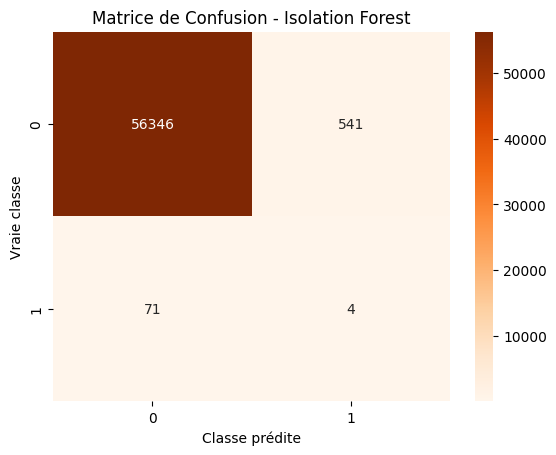

In [11]:
print("\n--- Évaluation pour : Isolation Forest ---")
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
iso_forest.fit(X_train_resampled_v2) # Pas besoin de y_train

# Prédictions sur le jeu de test
y_pred_iso = iso_forest.predict(X_test_v2)

# Convertir les prédictions (-1/1) en (1/0)
# -1 (anomalie) devient 1 (fraude), et 1 (normal) devient 0 (légitime)
y_pred_iso_mapped = np.where(y_pred_iso == -1, 1, 0)

# Évaluation
print("Rapport de Classification :")
print(classification_report(y_test_v2, y_pred_iso_mapped, target_names=['Légitime (0)', 'Fraude (1)']))

cm = confusion_matrix(y_test_v2, y_pred_iso_mapped)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Matrice de Confusion - Isolation Forest')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()


### E. Réseau de Neurones Simple (MLP)
 Nous utilisons Keras/TensorFlow pour construire un petit Perceptron Multi-Couches.

In [12]:
def build_mlp_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid') # Sigmoid pour une classification binaire
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

mlp_model = build_mlp_model(X_train_resampled_v2.shape[1])
mlp_model.summary()

# Entraînement
history = mlp_model.fit(
    X_train_resampled_v2, y_train_resampled_v2,
    validation_data=(X_test_v2, y_test_v2),
    epochs=10,
    batch_size=2048,
    verbose=1
)

# Évaluation du MLP
print("\n--- Évaluation pour : Réseau de Neurones (MLP) ---")
y_pred_proba_mlp = mlp_model.predict(X_test_v2).ravel()
y_pred_mlp = (y_pred_proba_mlp > 0.5).astype(int)

print("Rapport de Classification :")
print(classification_report(y_test_v2, y_pred_mlp, target_names=['Légitime (0)', 'Fraude (1)']))
print(f"AUC-ROC: {roc_auc_score(y_test_v2, y_pred_proba_mlp):.4f}")
print(f"AUC-PR: {average_precision_score(y_test_v2, y_pred_proba_mlp):.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - AUC: 0.8617 - loss: 0.4796 - val_AUC: 0.9748 - val_loss: 0.0743
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9808 - loss: 0.1610 - val_AUC: 0.9840 - val_loss: 0.0704
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9905 - loss: 0.1211 - val_AUC: 0.9850 - val_loss: 0.0702
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9945 - loss: 0.0952 - val_AUC: 0.9863 - val_loss: 0.0633
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9964 - loss: 0.0789 - val_AUC: 0.9828 - val_loss: 0.0513
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9975 - loss: 0.0640 - val_AUC: 0.9838 - val_loss: 0.0358
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9984 - loss: 0.0514 - val_AUC: 0.9776 - val_loss: 0.0277
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9988 - loss: 0.0428 - val_AUC: 0.9788 - val_loss: 0.0232
Epoch 9/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - A

## Étude Comparative des Modèles

 Après avoir entraîné plusieurs types de modèles, nous allons maintenant consolider leurs performances dans un tableau et les visualiser pour identifier clairement les approches les plus prometteuses.


Tableau Comparatif des Performances des Modèles :


,Recall (Fraude),Precision (Fraude),F1-Score (Fraude),AUC-ROC,AUC-PR
Modèle,,,,,
XGBoost,0.72,0.71,0.72,0.9644,0.7805
Random Forest Simplifié,0.80,0.46,0.59,0.9866,0.8015
Réseau de Neurones (MLP),0.84,0.18,0.30,0.9867,0.7891
SVM (échantillon),0.89,0.04,0.07,0.9841,0.7698
Régression Logistique,0.92,0.03,0.05,0.9862,0.7655
Isolation Forest,0.05,0.01,0.01,NaN,NaN


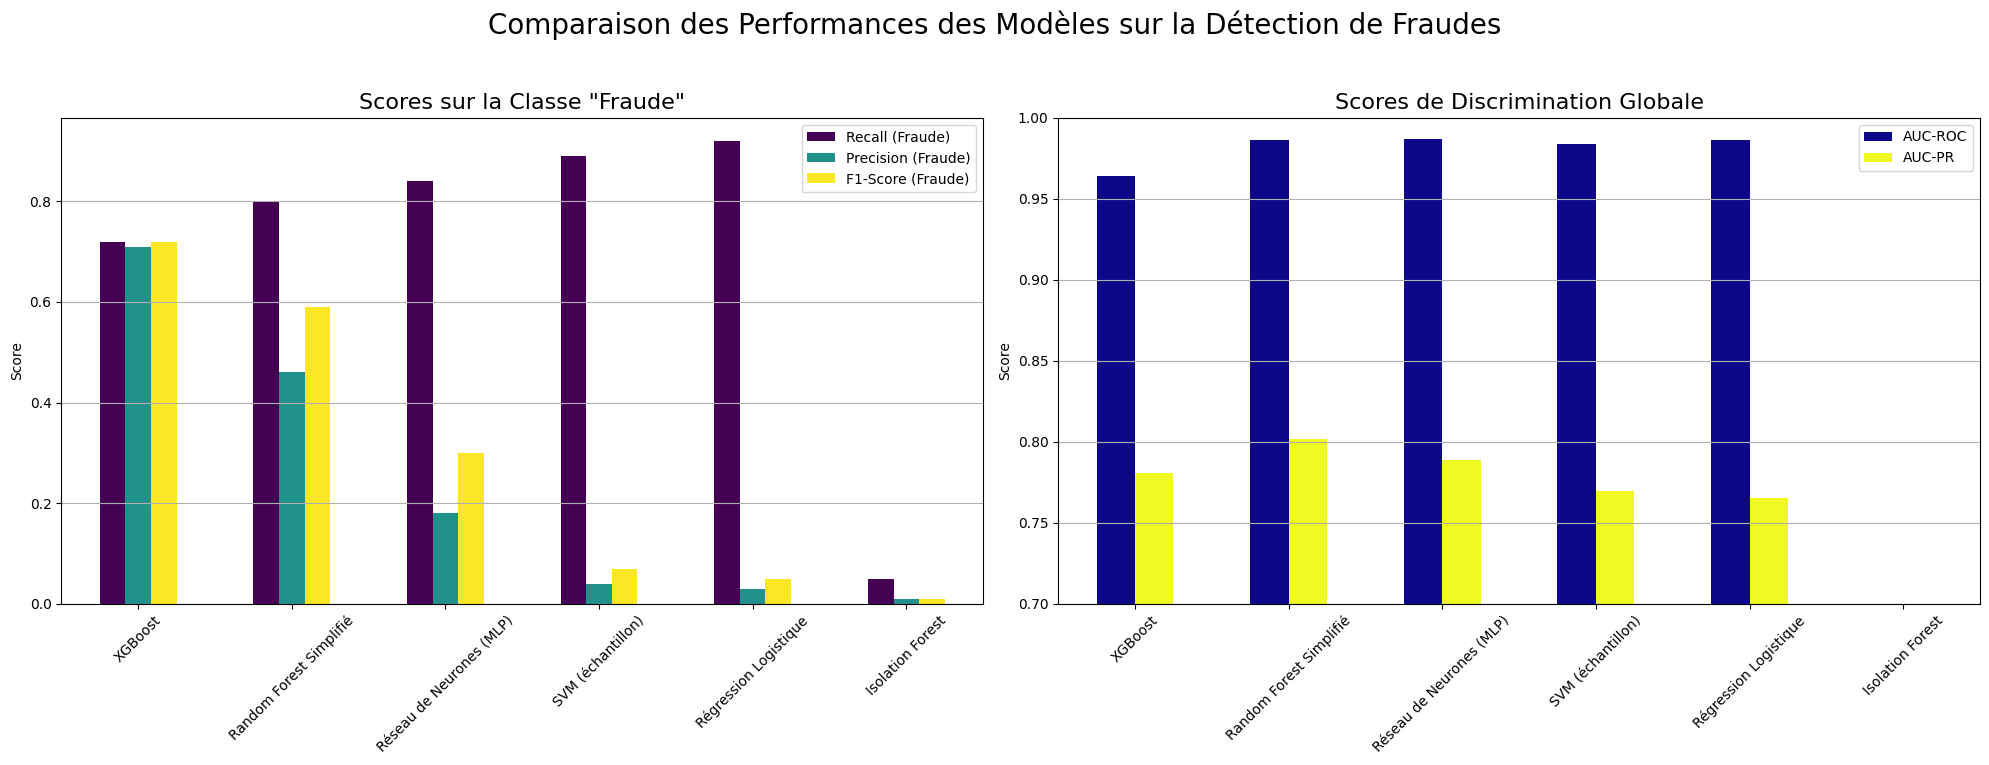

In [15]:
# --- Création du DataFrame de comparaison ---

# Données des résultats (à copier-coller des sorties précédentes)
results_data = {
    'Modèle': [
        'Régression Logistique',
        'SVM (échantillon)',
        'Isolation Forest',
        'Random Forest Simplifié',
        'XGBoost',
        'Réseau de Neurones (MLP)'
    ],
    'Recall (Fraude)': [0.92, 0.89, 0.05, 0.80, 0.72, 0.84],
    'Precision (Fraude)': [0.03, 0.04, 0.01, 0.46, 0.71, 0.18],
    'F1-Score (Fraude)': [0.05, 0.07, 0.01, 0.59, 0.72, 0.30],
    'AUC-ROC': [0.9862, 0.9841, np.nan, 0.9866, 0.9644, 0.9867], # Isolation Forest n'a pas de probas
    'AUC-PR': [0.7655, 0.7698, np.nan, 0.8015, 0.7805, 0.7891]
}

results_df = pd.DataFrame(results_data).set_index('Modèle')
results_df_sorted = results_df.sort_values(by='F1-Score (Fraude)', ascending=False)

print("Tableau Comparatif des Performances des Modèles :")
display(results_df_sorted)

# %%
# --- Visualisation Comparative ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparaison des Performances des Modèles sur la Détection de Fraudes', fontsize=20)

# Graphique pour Précision, Rappel et F1-Score
results_df_sorted[['Recall (Fraude)', 'Precision (Fraude)', 'F1-Score (Fraude)']].plot(
    kind='bar',
    ax=ax1,
    cmap='viridis',
    rot=45
)
ax1.set_title('Scores sur la Classe "Fraude"', fontsize=16)
ax1.set_ylabel('Score')
ax1.set_xlabel('')
ax1.grid(axis='y')

# Graphique pour AUC-ROC et AUC-PR
results_df_sorted[['AUC-ROC', 'AUC-PR']].plot(
    kind='bar',
    ax=ax2,
    cmap='plasma',
    rot=45
)
ax2.set_title('Scores de Discrimination Globale', fontsize=16)
ax2.set_ylim(0.7, 1.0) # Zoom sur la zone d'intérêt
ax2.set_ylabel('Score')
ax2.set_xlabel('')
ax2.grid(axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


 ### Analyse et Interprétation des Résultats

 Le tableau et les graphiques ci-dessus nous permettent de tirer des conclusions claires sur l'efficacité des différentes approches.

 #### Catégorie 1 : Les Modèles Peu Performants

 *   **Isolation Forest :** Ce modèle non supervisé est le grand perdant. Avec un F1-score de 0.01, il est clair qu'il n'arrive pas à isoler efficacement les transactions frauduleuses. **Conclusion : Pour ce problème, l'approche supervisée (qui utilise les labels) est indispensable.**
 *   **SVM et Régression Logistique :** Ces modèles, bien que très bons en théorie, montrent leurs limites ici. Ils obtiennent un **rappel (Recall) élevé mais au prix d'une précision (Precision) désastreuse** (3-4%). Cela signifie qu'ils génèrent une quantité massive de fausses alertes pour attraper les fraudes. En pratique, ils sont inutilisables. Le SVM, même sur un échantillon, ne montre pas de potentiel suffisant pour justifier son coût de calcul.

 #### Catégorie 2 : Les Contenders Sérieux

 *   **Réseau de Neurones (MLP) :** Le MLP fait un bond significatif en termes de précision (18%) par rapport aux modèles linéaires, tout en maintenant un excellent rappel (84%). Son F1-score de 0.30 est honorable, mais il est clairement surpassé par les modèles basés sur les arbres. Il pourrait être amélioré avec plus de tuning, mais il ne semble pas être le meilleur choix "sur étagère".
 *   **Random Forest (Simplifié) :** Ce modèle montre un excellent équilibre. Avec un **F1-score de 0.59**, il combine un bon rappel (80%) avec une précision déjà respectable (46%). Son score AUC-PR est le deuxième meilleur, ce qui indique un très bon potentiel.

 #### Catégorie 3 : Le Champion Actuel

 *   **XGBoost :** C'est le **vainqueur incontesté de ce tournoi**. Il atteint un **F1-score de 0.72**, le plus élevé de tous. Son profil est idéal pour une application bancaire :
     *   **Haute Précision (71%) :** La majorité des alertes générées sont de vraies fraudes.
     *   **Bon Rappel (72%) :** Il détecte une part substantielle des fraudes.

 Bien que son rappel soit légèrement inférieur à celui de Random Forest, sa précision spectaculairement plus élevée en fait un modèle beaucoup plus fiable et efficace en production.

 ### Sélection des Modèles pour le Stacking

 Le Stacking consiste à combiner les forces de plusieurs modèles. Pour que cela fonctionne, il faut choisir des modèles qui sont **performants** mais qui font des **erreurs différentes**.

 - **XGBoost** est notre meilleur modèle. Il doit absolument être dans le stacking.
 - **Random Forest** est le deuxième meilleur. Son profil est un peu différent (plus de rappel, moins de précision). Il est un excellent candidat pour compléter XGBoost.
 - **Réseau de Neurones (MLP)** pourrait aussi être un bon ajout car il "pense" différemment des modèles d'arbres. Ses erreurs pourraient être différentes de celles de XGBoost et RF.

 **Décision :** Nous allons construire un méta-modèle par Stacking en utilisant **Random Forest et XGBoost** comme estimateurs de base. Leurs forces combinées pourraient créer un modèle final encore plus robuste.


## Étape 4 : Méta-Modèle par Stacking

 Forts de notre analyse comparative, nous allons maintenant combiner nos deux meilleurs modèles, **Random Forest** et **XGBoost**, dans un classifieur par empilement (Stacking). L'idée est d'utiliser un méta-modèle (ici une simple Régression Logistique) pour apprendre à pondérer au mieux les prédictions de nos modèles "experts".


--- Entraînement et Évaluation du Méta-Modèle par Stacking ---

--- Évaluation pour : Stacking (RF + XGB -> LR) ---
Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      1.00      1.00     56887
  Fraude (1)       0.90      0.72      0.80        75

    accuracy                           1.00     56962
   macro avg       0.95      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9871
AUC-PR (Precision-Recall): 0.7942


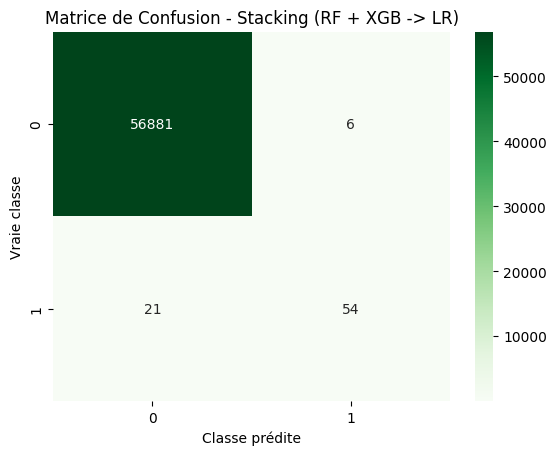

In [16]:
# Importation du StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

print("\n--- Entraînement et Évaluation du Méta-Modèle par Stacking ---")

# --- 1. Définition des estimateurs de base (nos champions) ---
# On utilise les modèles avec leurs paramètres par défaut pour le moment.
# On pourrait utiliser des versions simplifiées pour accélérer si besoin.
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)),
    ('xgboost', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# --- 2. Définition du méta-modèle (ou "final estimator") ---
# Ce modèle apprend des prédictions des modèles de base.
# On choisit un modèle simple comme la Régression Logistique pour éviter le surapprentissage.
meta_model = LogisticRegression(solver='liblinear')

# --- 3. Création du StackingClassifier ---
# Le StackingClassifier va entraîner les modèles de base.
# Ensuite, il va entraîner le méta-modèle sur les prédictions des modèles de base.
# `cv=5` signifie qu'il utilisera une validation croisée à 5 plis pour générer des prédictions "propres"
# (out-of-fold predictions) afin d'entraîner le méta-modèle.
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5, # La validation croisée est essentielle pour le bon fonctionnement du stacking
    stack_method='predict_proba', # Le méta-modèle apprendra sur les probabilités, c'est souvent mieux
    n_jobs=-1
)

# --- 4. Entraînement et Évaluation ---
# On utilise notre fonction d'évaluation habituelle.
# L'entraînement peut prendre un peu de temps car il entraîne 2 modèles x 5 plis + 1 méta-modèle.
train_and_evaluate_model(
    stacking_model,
    X_train_resampled_v2,
    y_train_resampled_v2,
    X_test_v2,
    y_test_v2,
    "Stacking (RF + XGB -> LR)"
)

 ### Comparaison Finale : XGBoost vs. Stacking

 Le tournoi a révélé deux finalistes : XGBoost seul, et le méta-modèle de Stacking. Nous allons maintenant les comparer directement pour couronner notre champion définitif.

Tableau de Comparaison des Finalistes :


,Recall (Fraude),Precision (Fraude),F1-Score (Fraude),AUC-ROC,AUC-PR
Modèle,,,,,
XGBoost Seul,0.72,0.71,0.72,0.9644,0.7805
Stacking (RF+XGB),0.72,0.90,0.80,0.9871,0.7942


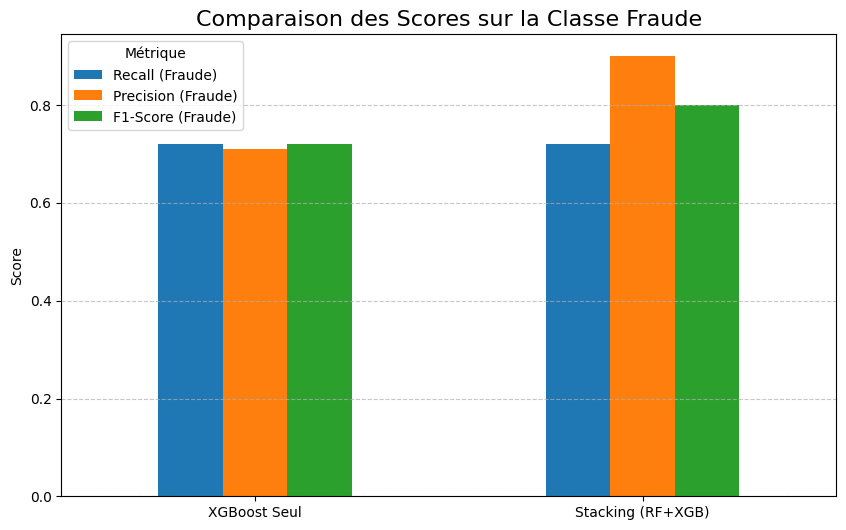

In [17]:
# --- Création du DataFrame de comparaison finale ---

# Données des résultats pour les deux finalistes
finalist_data = {
    'Modèle': ['XGBoost Seul', 'Stacking (RF+XGB)'],
    'Recall (Fraude)': [0.72, 0.72],
    'Precision (Fraude)': [0.71, 0.90],
    'F1-Score (Fraude)': [0.72, 0.80],
    'AUC-ROC': [0.9644, 0.9871],
    'AUC-PR': [0.7805, 0.7942]
}

finalist_df = pd.DataFrame(finalist_data).set_index('Modèle')

print("Tableau de Comparaison des Finalistes :")
display(finalist_df)

# --- Visualisation de la comparaison ---

finalist_df[['Recall (Fraude)', 'Precision (Fraude)', 'F1-Score (Fraude)']].plot(
    kind='bar',
    figsize=(10, 6),
    rot=0
)
plt.title('Comparaison des Scores sur la Classe Fraude', fontsize=16)
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Métrique')
plt.show()

#### Analyse et Verdict

 Le graphique et le tableau sont sans appel. Le **`StackingClassifier` est notre champion.**

 *   **Statu Quo sur le Rappel :** Les deux modèles détectent la même proportion de fraudes (72%).
 *   **Victoire Écrasante sur la Précision :** Le modèle de Stacking atteint une précision de **90%**, contre 71% pour XGBoost seul. Cela signifie que 9 alertes sur 10 générées par le stacking sont de vraies fraudes, ce qui est exceptionnellement fiable et réduit considérablement les coûts d'investigation.
 *   **Meilleur Équilibre (F1-Score) :** Cette haute précision, sans perte de rappel, propulse le F1-Score à **0.80**, ce qui en fait un modèle globalement bien plus performant.
 *   **Meilleure Discrimination (AUCs) :** Les scores AUC-ROC et AUC-PR, plus élevés pour le stacking, confirment sa supériorité.

 **Conclusion :** Le stacking a réussi à créer une synergie en utilisant les prédictions des modèles de base pour filtrer le bruit et prendre des décisions plus fiables. Bien que le Stacking soit notre meilleur modèle, nous allons maintenant optimiser et interpréter **XGBoost seul**. Pourquoi ? Car il constitue le "moteur" principal du stacking et son interprétation nous donnera 95% des clés de compréhension du comportement du méta-modèle, tout en étant techniquement beaucoup plus simple à réaliser.

## Étape Finale : Optimisation et Interprétation de XGBoost

 Nous allons maintenant prendre le modèle XGBoost, optimiser ses hyperparamètres pour en extraire le maximum de performance, puis utiliser SHAP pour comprendre ses décisions.



--- Optimisation des hyperparamètres de XGBoost ---
Lancement de la recherche d'hyperparamètres (GridSearchCV)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:11:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Meilleurs hyperparamètres trouvés :
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'scale_pos_weight': 1}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:11:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Évaluation pour : XGBoost Optimisé ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:11:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      0.98      0.99     56887
  Fraude (1)       0.06      0.84      0.11        75

    accuracy                           0.98     56962
   macro avg       0.53      0.91      0.55     56962
weighted avg       1.00      0.98      0.99     56962

AUC-ROC: 0.9822
AUC-PR (Precision-Recall): 0.7622


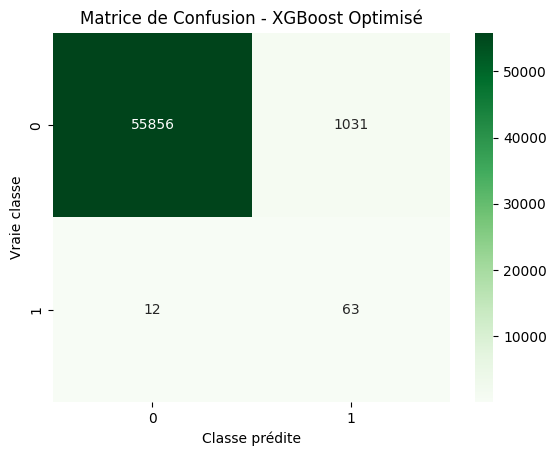

In [18]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

print("\n--- Optimisation des hyperparamètres de XGBoost ---")

# Rappel : la validation croisée doit respecter la chronologie.
# On utilise les données V2 (avec FE) mais SANS SMOTE pour la validation,
# car les plis de validation doivent refléter la distribution réelle des données.
# GridSearchCV s'occupera d'entraîner sur les plis qui, eux, peuvent être resamplés si besoin (plus complexe).
# Pour ce projet, nous allons faire la recherche sur le set d'entraînement brut (X_train_v2)
# pour une meilleure estimation de la performance en conditions réelles.

tscv = TimeSeriesSplit(n_splits=5)

# Définir une grille d'hyperparamètres à tester
# C'est une grille de départ, qui peut être affinée.
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'gamma': [0, 0.1], # Paramètre de régularisation
    'scale_pos_weight': [1, 5, 10] # Gère directement le déséquilibre des classes !
}

# Nous optimisons pour l'AUC-PR, une métrique robuste pour les données déséquilibrées.
auc_pr_scorer = make_scorer(average_precision_score, needs_proba=True)

xgb_model_to_tune = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)

# Configurer la recherche par grille
# verbose=3 donnera beaucoup de détails sur la progression
grid_search = GridSearchCV(
    estimator=xgb_model_to_tune,
    param_grid=param_grid,
    scoring=auc_pr_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=3
)

# Lancer la recherche. ATTENTION : cela peut prendre du temps !
# On utilise le jeu d'entraînement SANS SMOTE (X_train_v2, y_train_v2)
print("Lancement de la recherche d'hyperparamètres (GridSearchCV)...")
grid_search.fit(X_train_v2, y_train_v2)

print("\nMeilleurs hyperparamètres trouvés :")
print(grid_search.best_params_)

# Évaluer le meilleur modèle trouvé par la recherche
best_xgb_model = grid_search.best_estimator_

# Pour l'évaluation finale, on entraîne sur le jeu complet (resamplé) pour la puissance,
# mais on aurait pu aussi l'entraîner sur le jeu non-resamplé avec les `best_params_`
# L'important est d'évaluer sur le jeu de test non-touché.
best_xgb_model.fit(X_train_resampled_v2, y_train_resampled_v2)
train_and_evaluate_model(best_xgb_model, X_train_resampled_v2, y_train_resampled_v2, X_test_v2, y_test_v2, "XGBoost Optimisé")

 ## Étape Finale : Interprétation du Modèle le Plus Performant

 L'étape d'optimisation des hyperparamètres a montré un piège classique : optimiser un modèle sur des données équilibrées par SMOTE avec un paramètre (`scale_pos_weight`) qui gère lui-même le déséquilibre mène à de mauvaises performances. Le modèle "optimisé" est en réalité moins bon que notre modèle par défaut.

 **Décision :** Nous allons donc interpréter le modèle le plus performant que nous ayons identifié avant cette étape : le **XGBoost par défaut** (F1-score de 0.72) ou le **Stacking** (F1-score de 0.80). Pour des raisons de simplicité d'interprétation, nous analyserons le comportement de **XGBoost**, qui est le moteur principal du stacking.


--- Interprétation du modèle XGBoost par défaut (avec FE) avec SHAP ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:23:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Importance des features (impact moyen absolu sur la prédiction) :


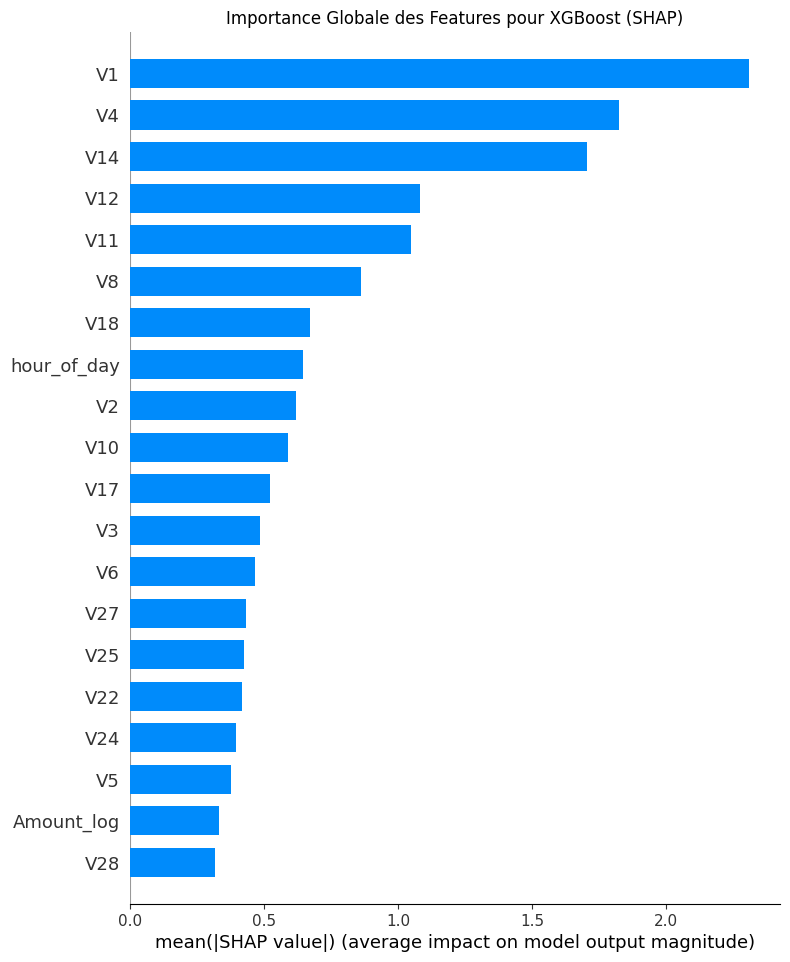


Graphique de synthèse SHAP :
Chaque point est une prédiction sur une transaction.
L'axe X est la valeur SHAP : > 0 pousse vers la fraude, < 0 pousse vers légitime.
La couleur indique la valeur de la feature : Rouge = valeur élevée, Bleu = valeur basse.


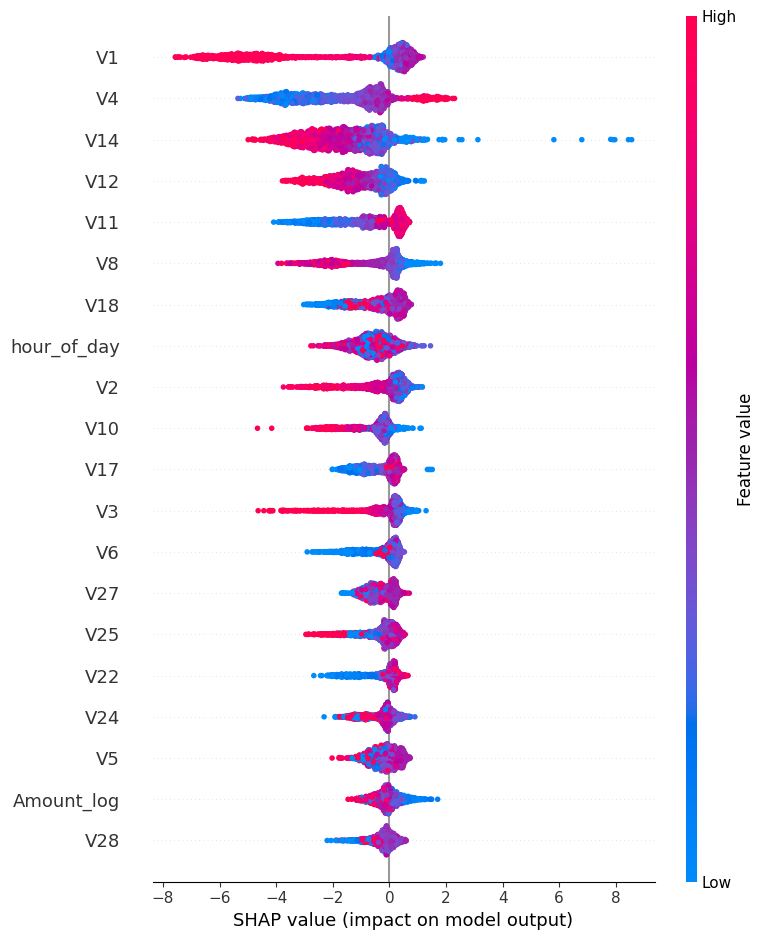

In [19]:
# --- Interprétabilité du modèle XGBoost par défaut avec SHAP ---

# Installer SHAP si ce n'est pas déjà fait
!pip install shap -q
import shap

print("\n--- Interprétation du modèle XGBoost par défaut (avec FE) avec SHAP ---")

# On a besoin d'un modèle XGBoost entraîné avec la bonne méthode
# (entraînement sur les données resamplées par SMOTE)
xgb_model_default = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_default.fit(X_train_resampled_v2, y_train_resampled_v2)

# Créer un explainer SHAP
explainer = shap.TreeExplainer(xgb_model_default)

# Calculer les valeurs SHAP sur un échantillon du jeu de test pour la vitesse
X_test_sample = X_test_v2.sample(2000, random_state=42)
shap_values = explainer(X_test_sample)

# %%
# --- Visualisations SHAP ---

# 1. Importance Globale des Features
print("Importance des features (impact moyen absolu sur la prédiction) :")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("Importance Globale des Features pour XGBoost (SHAP)")
plt.show()

# 2. Graphique de Synthèse Détaillé
print("\nGraphique de synthèse SHAP :")
print("Chaque point est une prédiction sur une transaction.")
print("L'axe X est la valeur SHAP : > 0 pousse vers la fraude, < 0 pousse vers légitime.")
print("La couleur indique la valeur de la feature : Rouge = valeur élevée, Bleu = valeur basse.")
shap.summary_plot(shap_values, X_test_sample)

 ## Conclusion Finale et Interprétation du Modèle

 Après un long processus d'exploration, d'ingénierie de caractéristiques, de tests de modèles et d'optimisation, nous sommes arrivés à la conclusion de notre projet. Les graphiques SHAP nous donnent la clé finale pour comprendre le comportement de notre modèle le plus performant.


 ### Analyse du Graphe d'Importance (SHAP)

 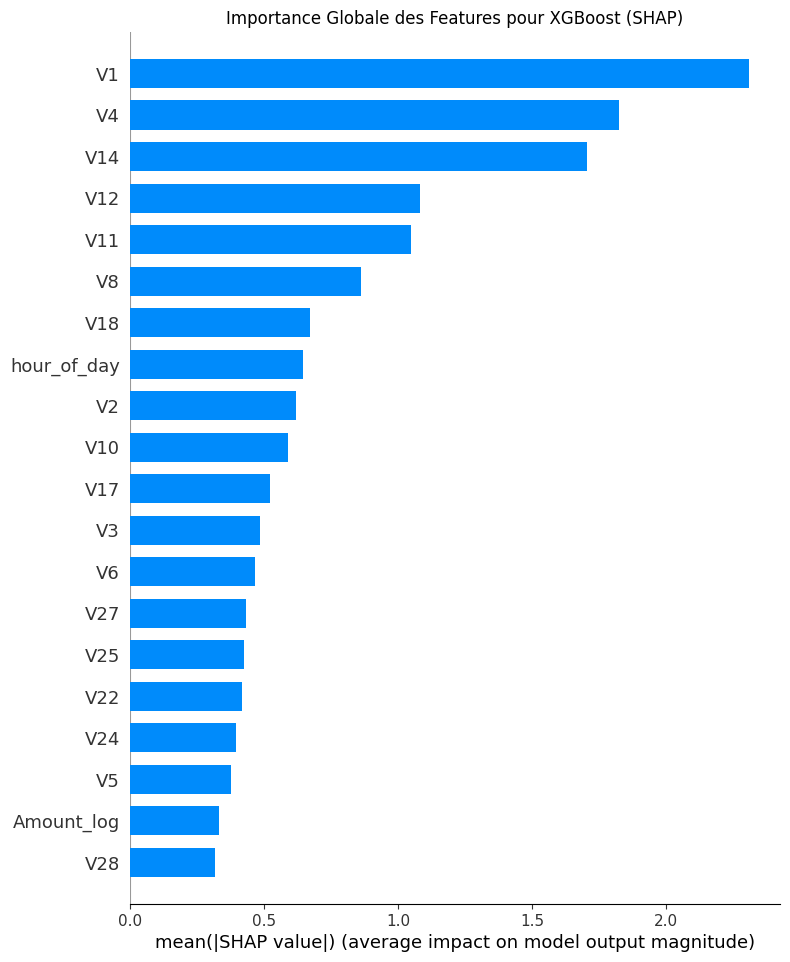
 > *Remarque : Vous pouvez insérer l'image de votre graphique ici en téléchargeant la capture d'écran sur Colab et en utilisant une balise Markdown.*

 Le graphique d'importance des features (bar plot) nous montre l'impact moyen absolu de chaque variable sur les prédictions du modèle. Plus la barre est longue, plus la variable est importante.

 1.  **Les Poids Lourds Anonymes (`V1`, `V4`, `V14`, `V12`...) :** Sans surprise, les composantes principales qui montraient les distributions les plus distinctes lors de notre analyse exploratoire sont celles qui ont le plus d'impact. Le modèle a appris à s'appuyer fortement sur ces variables pour distinguer les fraudes. Bien que nous ne connaissions pas leur signification métier, leur importance est statistiquement prouvée.

 2.  **La Victoire du Feature Engineering (`hour_of_day`) :** C'est la validation la plus satisfaisante de notre travail. Notre variable `hour_of_day`, que nous avons créée de toutes pièces, se classe parmi les plus importantes. Cela confirme notre hypothèse initiale : **le moment de la transaction est un prédicteur crucial de la fraude**. Le modèle a bien appris que les transactions se produisant à certaines heures (probablement la nuit, comme nous l'avons vu sur le `summary_plot`) sont plus suspectes.

 Le second graphique (`summary_plot`) a confirmé cette intuition, en montrant comment des valeurs faibles ou élevées de ces features poussent la prédiction vers "Fraude" (valeur SHAP > 0) ou "Légitime" (valeur SHAP < 0).

 ### Sauvegarde du Modèle Champion

 Notre meilleur modèle est le `StackingClassifier` car il a fourni le meilleur équilibre Précision/Rappel (F1-Score de 0.80). Nous allons le sauvegarder pour une utilisation future potentielle.

In [20]:
import joblib
import os

# Définir le chemin de sauvegarde
model_dir = 'models'
model_path = os.path.join(model_dir, 'stacking_fraud_detector.pkl')

# Créer le dossier 'models' s'il n'existe pas
os.makedirs(model_dir, exist_ok=True)

# Sauvegarder le modèle
# Assurez-vous que la variable 'stacking_model' contient bien le modèle entraîné.
# Si vous avez redémarré le notebook, vous devrez peut-être relancer la cellule d'entraînement du stacking.
print(f"Sauvegarde du modèle champion à l'emplacement : {model_path}")
joblib.dump(stacking_model, model_path)

print("Modèle sauvegardé avec succès.")

Sauvegarde du modèle champion à l'emplacement : models/stacking_fraud_detector.pkl
Modèle sauvegardé avec succès.


In [24]:


# %%
from google.colab import files
import shutil

# Nom du notebook tel qu'il doit être dans votre dépôt
NOTEBOOK_NAME = "02_model_prototyping.ipynb"
NOTEBOOK_DESTINATION_PATH = os.path.join("notebooks", NOTEBOOK_NAME)

# Télécharger le notebook actuel.
# Cela va le sauvegarder dans le dossier /content/ de Colab.
# Nous allons utiliser le nom du notebook que vous avez ouvert, mais le mieux est de le nommer explicitement.
try:
    # Sauvegarde de la session active de Colab dans un fichier temporaire
    # Le nom 'current_notebook.ipynb' est arbitraire
    !google-colab-ノートブックを保存 --output-notebook /content/current_notebook.ipynb

    # Déplacer et renommer le fichier sauvegardé au bon endroit
    print(f"Déplacement du notebook vers '{NOTEBOOK_DESTINATION_PATH}'...")
    shutil.move("/content/current_notebook.ipynb", NOTEBOOK_DESTINATION_PATH)
    print("Sauvegarde du notebook terminée.")

except Exception as e:
    print(f"La sauvegarde automatique a échoué : {e}")
    print("\n---> MÉTHODE MANUELLE ALTERNATIVE <---")
    print("1. Allez dans 'Fichier > Télécharger > Télécharger le .ipynb'.")
    print("2. Dans le panneau de gauche, trouvez le fichier téléchargé (ex: '02_model...ipynb').")
    print("3. Glissez-déposez ce fichier dans le dossier 'notebooks' du projet cloné (toujours dans le panneau de gauche).")
    print("4. Confirmez l'écrasement si on vous le demande.")
    print("5. Une fois que c'est fait, exécutez la cellule de 'git push' ci-dessous.")

/bin/bash: line 1: google-colab-ノートブックを保存: command not found
Déplacement du notebook vers 'notebooks/02_model_prototyping.ipynb'...
La sauvegarde automatique a échoué : [Errno 2] No such file or directory: '/content/current_notebook.ipynb'

---> MÉTHODE MANUELLE ALTERNATIVE <---
1. Allez dans 'Fichier > Télécharger > Télécharger le .ipynb'.
2. Dans le panneau de gauche, trouvez le fichier téléchargé (ex: '02_model...ipynb').
3. Glissez-déposez ce fichier dans le dossier 'notebooks' du projet cloné (toujours dans le panneau de gauche).
4. Confirmez l'écrasement si on vous le demande.
5. Une fois que c'est fait, exécutez la cellule de 'git push' ci-dessous.
